In [1]:
import numpy as np 
import obspy
import pandas as pd
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic

from tqdm import tqdm, trange
import time
import struct
from scipy import sparse
import scipy


## Functions

In [62]:
def read_spec(filepath, prec_wf='float32', prec_bp='int32'):
    """Function to read .spec files outputted by Peter Shearer's fortran
    codes.

    Args:
        filepath (str): Path of the .spec file to read

    Returns:
        shead: Spectral method header info
        ehead: Event header info
        spec: Spectra

    Sources:

    Last Modified:
        2024-09-03
    """

    f = open(filepath, 'rb')
    f.seek(0, 2)
    file_size = f.tell()
    f.seek(0, 0)

    spec = []

    shead = {}
    ehead = {}

    junk = struct.unpack('i', f.read(4))[0]
    shead['ispec_method'] = struct.unpack('i', f.read(4))[0]
    shead['ntwind'] = struct.unpack('i', f.read(4))[0]
    shead['nf'] = struct.unpack('i', f.read(4))[0]
    shead['twindoff'] = struct.unpack('f', f.read(4))[0]
    shead['dt'] = struct.unpack('f', f.read(4))[0]
    shead['df'] = struct.unpack('f', f.read(4))[0]    
    # print('shead: ', shead)

    junk1 = struct.unpack('i', f.read(4))[0]
    junk2 = struct.unpack('i', f.read(4))[0]
    # print('junk1: ', junk1)
    # print('junk2: ', junk2)
    ehead['efslabel'] = f.read(40).decode('UTF-8').strip('\x00')
    # print("efslabel: ", ehead['efslabel'])
    ehead['datasource'] = f.read(40).decode('UTF-8').strip('\x00')
    ehead['maxnumts'] = struct.unpack('i', f.read(4))[0]
    ehead['numts'] = struct.unpack('i', f.read(4))[0]
    ehead['cuspid'] = struct.unpack('i', f.read(4))[0]
    ehead['qtype'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmag1type'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmag2type'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmag3type'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qmomenttype'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qlocqual'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qfocalqual'] = f.read(4).decode('UTF-8').strip('\x00')
    ehead['qlat'] = struct.unpack('f', f.read(4))[0]
    ehead['qlon'] = struct.unpack('f', f.read(4))[0]
    ehead['qdep'] = struct.unpack('f', f.read(4))[0]
    ehead['qsc'] = struct.unpack('f', f.read(4))[0]
    ehead['qmag1'] = struct.unpack('f', f.read(4))[0]
    ehead['qmag2'] = struct.unpack('f', f.read(4))[0]
    ehead['qmag3'] = struct.unpack('f', f.read(4))[0]
    ehead['qmoment'] = struct.unpack('f', f.read(4))[0]
    ehead['qstrike'] = struct.unpack('f', f.read(4))[0]
    ehead['qdip'] = struct.unpack('f', f.read(4))[0]
    ehead['qrake'] = struct.unpack('f', f.read(4))[0]
    ehead['qyr'] = struct.unpack('i', f.read(4))[0]
    ehead['qmon'] = struct.unpack('i', f.read(4))[0]
    ehead['qdy'] = struct.unpack('i', f.read(4))[0]
    ehead['qhr'] = struct.unpack('i', f.read(4))[0]
    ehead['qmn'] = struct.unpack('i', f.read(4))[0]
    # print('ehead: ', ehead)

    # 20 4-byte fields reserved for future uses - skip (80 bytes)
    for idum in range(0, 20):
        dummy = struct.unpack('i', f.read(4))[0]
        # print(str(dummy) + ", ", end="")
    # print("")
    # dummy = struct.unpack('i', f.read(80))[0]

    # Get byte positions for all time series (i64 or i32 arrays)
    # bytepos = np.fromfile(f, dtype = prec_bp, count = ehead['numts'])
    # ehead['bytepos'] = bytepos

    # print(bytepos)

    # bytepos[0] += 4

    # Now loop over all the time series
    for ii in range(0, ehead['numts']):
        # print("TSSHEAD %i of %i\n---------------------" % (ii, ehead['numts']))

        # Assemble tshead
        # f.seek(bytepos[ii]+40)
        # print(bytepos[ii])
        tshead = {}
        junk1 = struct.unpack('i', f.read(4))[0]
        junk2 = struct.unpack('i', f.read(4))[0]
        
        # print(junk1, junk2)
        tshead['stname'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['loccode'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['datasource'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['sensor'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['units'] = f.read(8).decode('UTF-8').strip('\x00')
        tshead['chnm'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['stype'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['dva'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick1q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick2q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick3q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick4q'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick1name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick2name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick3name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['pick4name'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['ppolarity'] = f.read(4).decode('UTF-8').strip('\x00')
        # print(tshead)
        tshead['problem'] = f.read(4).decode('UTF-8').strip('\x00')
        tshead['npts'] = struct.unpack('i', f.read(4))[0]
        tshead['syr'] = struct.unpack('i', f.read(4))[0]
        tshead['smon'] = struct.unpack('i', f.read(4))[0]
        tshead['sdy'] = struct.unpack('i', f.read(4))[0]
        tshead['shr'] = struct.unpack('i', f.read(4))[0]
        tshead['smn'] = struct.unpack('i', f.read(4))[0]
        tshead['compazi'] = struct.unpack('f', f.read(4))[0]
        tshead['compang'] = struct.unpack('f', f.read(4))[0]
        tshead['gain'] = struct.unpack('f', f.read(4))[0]
        tshead['f1'] = struct.unpack('f', f.read(4))[0]
        tshead['f2'] = struct.unpack('f', f.read(4))[0]
        tshead['dt'] = struct.unpack('f', f.read(4))[0]
        tshead['ssc'] = struct.unpack('f', f.read(4))[0]
        tshead['tdif'] = struct.unpack('f', f.read(4))[0]
        tshead['slat'] = struct.unpack('f', f.read(4))[0]
        tshead['slon'] = struct.unpack('f', f.read(4))[0]
        tshead['selev'] = struct.unpack('f', f.read(4))[0]
        tshead['deldist'] = struct.unpack('f', f.read(4))[0]
        tshead['sazi'] = struct.unpack('f', f.read(4))[0]
        tshead['qazi'] = struct.unpack('f', f.read(4))[0]
        tshead['pick1'] = struct.unpack('f', f.read(4))[0]
        tshead['pick2'] = struct.unpack('f', f.read(4))[0]
        tshead['pick3'] = struct.unpack('f', f.read(4))[0]
        tshead['pick4'] = struct.unpack('f', f.read(4))[0]
        # print(tshead)

        # print('dummy: ', end="")
        # 20 4-byte fields reserved for future uses - skip
        for idum in range(0, 22):
            dummy = struct.unpack('i', f.read(4))[0]
            # print(str(dummy) + ", ", end="")
        # dummy = struct.unpack('i', f.read(80))[0]
        # print("")

        # Read the windowed data and spectra
        x1out = np.fromfile(f, dtype = prec_wf, count = shead['ntwind'])
        x2out = np.fromfile(f, dtype = prec_wf, count = shead['ntwind'])

        s1out = np.fromfile(f, dtype = prec_wf, count = shead['nf'])
        s2out = np.fromfile(f, dtype = prec_wf, count = shead['nf'])

        # Bundle tsheader and time-series for this waveform into efsdata, then append to list
        tshead['x1'] = x1out
        tshead['x2'] = x2out
        tshead['s1'] = s1out
        tshead['s2'] = s2out
        spec.append(tshead)

        # some have fewer spectra than numts for some reason
        if file_size - f.tell() < 10: break
        # print("%i of %i bytes remaining" % (file_size - f.tell(), file_size))
        # print('first data: ', x1out[:10])
        # print('second spect: ', s2out[-10:])

        # plt.figure()
        # plt.plot(s1out)
        # plt.plot(s2out)
        # plt.show()
    f.close()

    ehead['numts'] = len(spec)

    return shead, ehead, spec

def p_norm(v, p):
    """Return the p-norm of a vector v (see ref. [2])

    Args:
        v (np.ndarray): array to calculate p-norm of
        p (int): p for p-norm

    Returns:
        float: p-norm of v
    """
    return np.power(np.sum(np.power(np.abs(v), p)), 1/p)

def model_p_norm(m, model_function, t, d, p):
    """Intermediate function for calculating the p-norm.

    Args:
        m (array-like): array of model parameters
        model_function (function): callable function
        t (np.ndarray): independent variable
        d (np.ndarray): data array
        p (int): p for p-norm

    Returns:
        float: p-norm of the residual (expected - observed) array
    """
    y = model_function(m, t)
    return p_norm(y - d, p)

def fit_p_norm(x, d, model, m0, p, **kwargs):
    """Find a fit to a model using scipy.optimize.minimize()

    Args:
        x (np.ndarray): independent variable
        d (np.ndarray): observations
        model (function): callable function, with inputs m (model 
            params) and x
        m0 (array-like): starting values for model parameters
        p (int): integer for choosing p-norm (1: L1-norm, 2: L2-norm, 
            etc.)

    Returns:
        np.ndarray: Best-fit model parameters
    """
    from scipy.optimize import minimize
    res = minimize(model_p_norm, m0, args=(model, x, d, p), **kwargs)
    return res.x

def fit_p_norm_log_resampled(x, d, model, m0, p, n=500, **kwargs):
    x_resamp = 10**(np.linspace(np.log10(x[0]), np.log10(x[-1]), n))
    d_resamp = np.interp(x_resamp, x, d)
    return fit_p_norm(x_resamp, d_resamp, model, m0, p, **kwargs)

def general_model(m, f):
    # calculate a general fault falloff model,
    # outputs in log
    # Shearer (2019) eq. 9.37
    # m = (logomega0, fc, n, gamma)
    # for Brune model, n=2 and gamma=1
    logomega0 = m[0]
    fc = m[1]
    n = m[2]
    gamma = m[3]
    
    return logomega0 - (1./gamma) * np.log10(1 + np.power(f / fc, n * gamma)).T

def brune_model(m, f):
    logomega0 = m[0]
    fc = m[1]
    n = 2.0
    gamma = 1.0
    return general_model([logomega0, fc, n, gamma], f)


## Parameters

In [57]:
### SpecDecomp parameters
travel_time_bin_increment       = 2             # Travel-time bin width (s)

### post-SpecDecomp processing

# Calibration events parameters (method from Shearer et al. 2022)
calibration_mag                 = [1.4, 1.6]    # Calibration event magnitude range
calibration_dist                = 40            # Max target-calibration event horizontal distance (km)
calibration_depth               = 5             # Max target-calibration vertical distance (km)
calibration_nmin                = 5             # Min number of calibration events for a target event
calibration_fc                  = 30.0          # Corner frequency to fix calibration events to (Hz)

# Source parameter estimation settings
target_mag_min                  = 1.6           # Min size of events to estimate parameters for
f_moment_est                    = 2.5           # Approx. freq. point to estimate moment at (Hz)
model_fit_f_range               = [2.5, 35]     # Approx. freq. range to fit Brune model to (Hz)
kP                              = 0.38          # from Kaneko and Shearer 2014
beta                            = 3464.0        # shear wave velocity (m/s)
Mw_correction_range             = [3.5, 6.0]    # Range of Mw events to estimate moment correction from
fc_bounds                       = [0.001, 200]  # Bounds for corner frequency fitting
logomega0_bounds                = [-10, 20]     # Bounds for log omega0

# Data directories
spec_dir = "data/spec_files/"                   # Folder containing .spec files
procspec_dir = "data/proc_spec/"                # Parent folder for output files


## Load data from .spec files
- This section reads .spec files into a pandas DataFrame, 'data'. Each line represents a station-event pair. Because of this, there is repeated information here (all station-event pairs of event 1234 will have the same values of magnitude, earthquake location, etc.). 
- The *keys objects hold column names that are dependent on station, event, and station-event pairs, and will be useful later on when using pd.groupby(). 
- Assign unique integer station, event, and travel-time bin indices to each. This will make the inverse problem setup later on much easier.
- If successful, data is saved in procspec_dir as 'data_table.pkl'. To re-import data, delete this file.

In [112]:
nf

151

In [111]:
# These lists hold the names of the values for the following:
#   skeys: values that depend solely on station
#   ekeys: values that depend solely on event
#   pkeys: values that depend on the event-station pair
#   ev_pkeys: same as above, but without x2 and s2 arrays
skeys      =  ['slat','slon','selev','units']
ekeys      =  ['cuspid','numts','qmag1','qmag1type','qlat','qlon','qdep','qsc']
pkeys      =  ['npts','dt','tdif','deldist','pick1','x2','s2']
ev_pkeys   =  ['npts','dt','tdif','deldist','pick1']
allkeys    =  [*ekeys, *skeys, *pkeys]

# Create bin edges for travel-time bins (seconds)
tt_bins = np.arange(0, 50, travel_time_bin_increment)


spec_files = [el for el in os.listdir(spec_dir) if el.endswith('.spec')]

shead, _, _ = read_spec(spec_dir + spec_files[0])

ntwind      = shead['ntwind']
nf          = shead['nf']
twindoff    = shead['twindoff']
dt          = shead['dt']
df          = shead['df'] / 2 # bug when saving shead. fix later

f = np.arange(0, nf) * df

try:
    data = pd.read_pickle(procspec_dir + "data_table.pkl")
    event_ids = np.loadtxt(procspec_dir + "event_ids.txt", dtype=int)
    station_ids = np.loadtxt(procspec_dir + "station_ids.txt", dtype=str)
    print("DataFrame successfully loaded")
except:
    print("Failed to load pre-computed DataFrame. Computing now...")
    skeys += ['stype', 'stname', 'loccode', 'chnm']
    D = []
    for i in trange(len(spec_files), desc='Reading .spec files: '):
        filepath = spec_dir + spec_files[i]
        # read .spec files
        shead, ehead, spec = read_spec(filepath)

        edata = {key: ehead[key] for key in ekeys}

        for j in range(len(spec)):
            sdata = {key: spec[j][key] for key in skeys}
            pdata = {key: spec[j][key] for key in pkeys}
            D.append({**edata, **sdata, **pdata})
    data = pd.DataFrame(D)
    # combine these columns into a single station identifier
    data['station_id'] = data[['stype', 'stname', 'loccode', 'chnm']].apply(lambda x: '.'.join(x[x.notnull()]), axis=1)
    
    # drop these columns since they're no longer useful
    data = data.drop(labels=['stype', 'stname', 'loccode', 'chnm'], axis='columns')
    for el in ['stype', 'stname', 'loccode', 'chnm']:
        skeys.remove(el)

    # for some reason, some values of 'pick1' are zero. Toss these.
    data = data.drop(np.where(data['pick1'].values==0.0)[0])

    # bin values by travel time
    data['ttind'] = np.searchsorted(tt_bins, data['pick1'].values.astype(float)) - 1

    # assign event- and station-specific integer ids   
    event_ids = np.unique(data['cuspid'].values)
    station_ids = np.unique(data['station_id'].values)
    event_ids.sort()
    station_ids.sort()
    data['stind'] = [np.where(el == station_ids)[0][0] for el in data['station_id'].values]
    data['evind'] = [np.where(el == event_ids)[0][0] for el in data['cuspid'].values]
    
    # sort, re-index, and save
    data.sort_values(by=['cuspid', 'station_id'], inplace=True)
    data.reset_index(inplace=True, drop=True)
    data.to_pickle(procspec_dir + "data_table.pkl")
    np.savetxt(procspec_dir + "event_ids.txt", event_ids, fmt='%i', delimiter='\n')
    np.savetxt(procspec_dir + "station_ids.txt", station_ids, fmt='%s', delimiter='\n')
    print(f"Saved data_table.pkl in {procspec_dir}")

# append new values to the keys lists
skeys += ['station_id', 'stind']
ekeys += ['evind']
pkeys += ['ttind']
ev_pkeys += ['ttind']

# truncate travel-time bins to maximum used
tt_bins = tt_bins[:len(np.unique(data['ttind']))+1]

ndata = len(data)
nstations = max(data['stind']) + 1
nevents = max(data['evind']) + 1
nttbins = len(tt_bins) - 1

data.head()

DataFrame successfully loaded


,cuspid,numts,qmag1,qmag1type,qlat,qlon,qdep,qsc,slat,slon,...,dt,tdif,deldist,pick1,x2,s2,station_id,ttind,stind,evind
0,71111674,9,2.79,Md,37.645168,-118.879669,4.18,5.93,37.630192,-118.836052,...,100.0,-30.0,4.193274,1.539544,"[164.42667, 28.426666, 13.426666, 34.426666, -...","[31875568.0, 31875568.0, 15431679.0, 11958157....",CI.MLAC..HHZ,0,29,0
1,71111674,9,2.79,Md,37.645168,-118.879669,4.18,5.93,37.630192,-118.836052,...,100.0,-30.0,4.193274,1.539544,"[-5.01, -2.01, 1.99, 0.99, -4.01, -4.01, -1.01...","[21577.164, 21577.164, 5804.609, 2987.3088, 32...",CI.MLAC..HNZ,0,30,0
2,71111674,9,2.79,Md,37.645168,-118.879669,4.18,5.93,37.644394,-118.896835,...,100.0,-30.0,1.517604,1.178186,"[272.66, 178.66, -1.34, -143.34, -129.34, -106...","[19414928.0, 19414928.0, 14548448.0, 10224373....",NC.MCB..HHZ,0,39,0
3,71111674,9,2.79,Md,37.645168,-118.879669,4.18,5.93,37.644394,-118.896835,...,100.0,-30.0,1.517604,1.178186,"[0.71666664, -2.2833333, -4.2833333, -1.283333...","[225904.94, 225904.94, 57632.836, 25795.023, 1...",NC.MCB..HNZ,0,40,0
4,71111674,9,2.79,Md,37.645168,-118.879669,4.18,5.93,37.618992,-118.862953,...,100.0,-30.0,3.258258,1.389030,"[-0.09, 1.91, -0.09, -0.09, -0.09, -3.09, 1.91...","[114915.484, 114915.484, 29842.54, 13112.405, ...",NC.MCO..HNZ,0,41,0


(array([2591., 4731., 2580., 2208., 5128., 1714.,  982.,  834., 1483.,
        1524.,    9.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

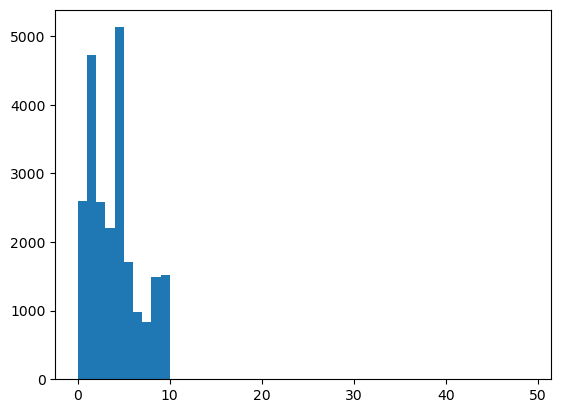

In [81]:
plt.hist(data['ttind'], bins=np.arange(50))

## Inverse problem and solution

Setup & solve the following inverse problem:

\begin{equation}
d = Gm
\end{equation}

In [93]:
# form an (ndata x nf) matrix of log spectra
d = np.log10(np.array([el.reshape((nf)) for el in data['s2'].values]))

# Ge, Gs, and Gr represent the event, station, and distance blocks of G
# d and i arrays are the same for each block: d is just ones, and i are the
# row numbers
d_array = np.ones(ndata, dtype=int) # values at coordinates i,j
i_array = np.arange(ndata, dtype=int) # i coordinates

# Events
j_array = data['evind'].values.astype(int) # j coordinates
Ge = sparse.csc_matrix((d_array, (i_array, j_array)), dtype=int)

# Stations
j_array = data['stind'].values.astype(int) # j coordinates
Gs = sparse.csc_matrix((d_array, (i_array, j_array)), dtype=int)

# Distances
j_array = data['ttind'].values.astype(int) # j coordinates
Gr = sparse.csc_matrix((d_array, (i_array, j_array)), dtype=int)

# stabilization?

# stack all blocks together
G = sparse.hstack((Ge, Gs, Gr))

print("d array shape:                    ", d.shape)
print("-------------------------------------------------")
print("Event block (Ge) shape:           ", Ge.shape)
print("Station block (Gs) shape:         ", Gs.shape)
print("Travel-time bin block (Gr) shape: ", Gr.shape)
print("-------------------------------------------------")
print("Resulting G matrix shape:         ", G.shape)
print("-------------------------------------------------")


# solve the inverse problem at each frequency point
# split into event, station, and distance terms
print("Solving d=Gm at each frequency index...")
e = np.empty((nevents, nf), dtype=float)
s = np.empty((nstations, nf), dtype=float)
t = np.empty((nttbins, nf), dtype=float)
for i in trange(nf):
    # solve using your choice of solver
    x = sparse.linalg.lsqr(G, d[:,i], iter_lim=10000)

    # Separate the event, station, and travel-time terms
    e[:,i] = x[0][:nevents]
    s[:,i] = x[0][nevents:nevents+nstations]
    t[:,i] = x[0][nevents+nstations:]
print("Done.")
print("-------------------------------------------------")

# data['ev_term'] = [el.flatten() for el in np.vsplit(e[np.searchsorted(event_ids, data['cuspid'].values),:], ndata)]
# data['st_term'] = [el.flatten() for el in np.vsplit(s[np.searchsorted(station_ids, data['station_id'].values),:], ndata)]
# data['tt_term'] = [el.flatten() for el in np.vsplit(t[np.searchsorted(tt_bins, data['ttind'].values),:], ndata)]

# save the event, station, and travel-time terms separately
ev_terms = pd.DataFrame({
    'event_id': event_ids,
    'ev_term': [el.flatten() for el in np.vsplit(e, nevents)]})
st_terms = pd.DataFrame({
    'station_id': station_ids,
    'st_term': [el.flatten() for el in np.vsplit(s, nstations)]})
tt_terms = pd.DataFrame({
    't0': tt_bins[:-1],
    't1': tt_bins[1:],
    'tt_term': [el.flatten() for el in np.vsplit(t, nttbins)]})
ev_terms.to_csv(procspec_dir + "ev_terms.txt", index=False, header=False)
st_terms.to_csv(procspec_dir + "st_terms.txt", index=False, header=False)
tt_terms.to_csv(procspec_dir + "tt_terms.txt", index=False, header=False)
print(f"Saved event, station, and travel-time terms in {procspec_dir}")

# form a dataframe with one line per event, and group station-dependent values in lists.
# including 'ev_term' column didn't work here (might be another way).
ev = data[skeys+ekeys+ev_pkeys].groupby(ekeys, as_index=False)[skeys+ev_pkeys].agg(list)

# merge ev_term back into ev object
ev = pd.merge(ev, ev_terms, how='left', left_on='cuspid', right_on='event_id')
print("Data grouped into DataFrame 'ev': one row per event")

# estimate moment from the low-frequency point
moment_est_ind = np.argmin(np.abs(f - f_moment_est))
ev['logomega0est'] = ev['ev_term'].apply(lambda x: np.median(x[moment_est_ind-1:moment_est_ind+2]))
print("Done.")


d array shape:                     (23784, 151)
-------------------------------------------------
Event block (Ge) shape:            (23784, 3125)
Station block (Gs) shape:          (23784, 80)
Travel-time bin block (Gr) shape:  (23784, 11)
-------------------------------------------------
Resulting G matrix shape:          (23784, 3216)
-------------------------------------------------
Solving d=Gm at each frequency index...


100%|██████████| 151/151 [00:19<00:00,  7.59it/s]


Done.
-------------------------------------------------
Saved event, station, and travel-time terms in data/proc_spec/
Data grouped into DataFrame 'ev': one row per event
Done.


In [6]:
# ttmids = (tt_bins[1:] + tt_bins[:-1]) / 2
# plt.figure(figsize=(10,8))
# for i in range(nttbins):    
#     plt.plot(f, t[i,:], c=[1,i/nttbins,0], label=ttmids[i])
# plt.legend()
# plt.title(f'Travel-time terms (n = {nttbins})')
# plt.show()

# plt.figure(figsize=(10,8))
# plt.plot(f, s.T)
# plt.title(f'Station terms (n = {nstations})')
# plt.show()

# plt.figure(figsize=(10,8))
# plt.plot(f, e.T, c='k', linewidth=0.1)
# plt.title(f'Event terms (n = {nevents})')
# plt.show()



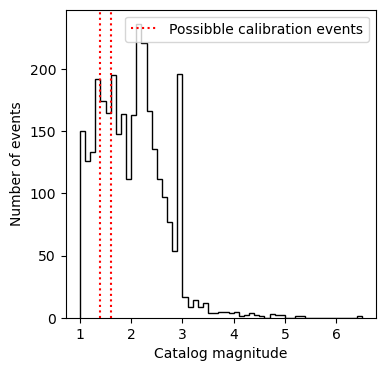

In [94]:
plt.figure(figsize=(4,4))
plt.hist(ev['qmag1'], bins=np.arange(1, 6.6, 0.1), histtype='step', color='k')
plt.axvline(calibration_mag[0], c='r', linestyle=':', label='Possibble calibration events')
plt.axvline(calibration_mag[1], c='r', linestyle=':')
plt.legend(loc='upper right')
plt.xlabel("Catalog magnitude")
plt.ylabel("Number of events")
plt.show()

In [66]:
# Dataframe of all possible calibration events
ev_calib = ev[np.logical_and(
    ev['qmag1'] >= calibration_mag[0],
    ev['qmag1'] <  calibration_mag[1]
)].reset_index(drop=True)
ev_target = ev[ev['qmag1'] >= target_mag_min].reset_index(drop=True)
ncalib_possible = len(ev_calib)
ntarget = len(ev_target)


print(f"{ncalib_possible} possible calibration events ({nevents} events total)")
print(f"{ntarget} possible target events ({nevents} events total)")

ev_target['logomega0'] = np.zeros(ntarget, dtype=float) - 99.0
ev_target['fc'] = np.zeros(ntarget, dtype=float) - 99.0


fit_ind = [np.argmin(np.abs(f - el)) for el in model_fit_f_range]
fit_ind[1] += 1
for i in trange(ntarget, desc='Computing ECS and fitting Brune models: '):
    # for i, row in ev_target.iterrows():
    row = ev_target.iloc[i]

    # get distances to all calibration-sized events
    dists = np.array([geodesic(
        row[['qlat', 'qlon']].values, 
        (ev_calib.at[i, 'qlat'], ev_calib.at[i, 'qlon'])
    ).km for i in range(ncalib_possible)])

    # store depths as well
    depths = ev_calib['qdep'].values

    # find where calibration events are within required distance and depth
    # of target event
    calib_bool = np.logical_and(
        dists <= calibration_dist,
        np.abs(depths - row['qdep']) <= calibration_depth
    )
    
    calib = ev_calib[calib_bool].reset_index(drop=True)
    ncalib = len(calib)
    
    if ncalib >= calibration_nmin:

        calib_median_ev_term = np.median(np.stack(calib['ev_term'].values), axis=0)
        calib_median_logomega0 = np.median(calib_median_ev_term[moment_est_ind-1:moment_est_ind+2])

        # generate a Brune model with the estimated moment and fixed fc
        calib_model = brune_model([calib_median_logomega0, calibration_fc], f)

        # compute the ECS as the difference
        ecs = calib_median_ev_term - calib_model
        # smoothing?

        # Correct the target's ev_term using the ECS
        ev_term_corrected = row['ev_term'] - ecs
        est_logomega0 = (np.median(ev_term_corrected[moment_est_ind-1:moment_est_ind+2]))

        # Fit a Brune model to the corrected spectrum. Resample as log-spaced
        # frequency to avoid biasing fit toward the higher frequencies.
        fit_logomega0, fit_fc = fit_p_norm_log_resampled(
            f[fit_ind[0]:fit_ind[1]], 
            ev_term_corrected[fit_ind[0]:fit_ind[1]], 
            brune_model,
            [est_logomega0, np.mean(model_fit_f_range)], 
            p=1,
            bounds=[logomega0_bounds, fc_bounds]
            )
        
        # Make sure fc is reasonable
        # if fit_fc <= 0: fit_fc = 0.01
        # if fit_fc >= 0:
        ev_target.at[i, 'logomega0'] = fit_logomega0
        ev_target.at[i, 'fc'] = fit_fc

        # print(est_logomega0, fit_logomega0, fit_fc)


        # plt.figure()
        # for i, el in enumerate(calib['ev_term'].values):
        #     plt.plot(f, el, c='k', linewidth=0.2)
        #     # plt.scatter(f[moment_est_ind], calib['logomega0est'].values[i], c='k', s=5)
        # plt.plot(f, calib_model, c='r', zorder=11, label='Assumed Brune model')
        # plt.plot(f, calib_median_ev_term, c='k', linewidth=4, zorder=10, label='Median calibration event term')
        # plt.plot(f, ecs, c='b', linewidth=4, zorder=11, label='ECS')
        # plt.plot(f, ev_term_corrected, c='orange', linewidth=4, zorder=11, label='Corrected target event spectrum')
        # plt.plot(f, row['ev_term'], c='pink', linewidth=4, zorder=11, label='Uncorrected target event spectrum')
        # plt.plot(f, brune_model([fit_logomega0, fit_fc], f), c='lime', linewidth=4, zorder=11, label='Fit Brune model')
        # plt.xscale('log')
        # plt.axvline(f[fit_ind[0]])
        # plt.axvline(f[fit_ind[1]])
        # plt.legend(loc='lower left')
        # plt.show()
        # raise ValueError()

ev_target = ev_target[ev_target['logomega0'].values!=-99.0].reset_index(drop=True)
print(f"{len(ev_target)} events remain")


339 possible calibration events (3125 events total)
2185 possible target events (3125 events total)


Computing ECS and fitting Brune models: 100%|██████████| 2185/2185 [05:50<00:00,  6.23it/s]

1069 events remain


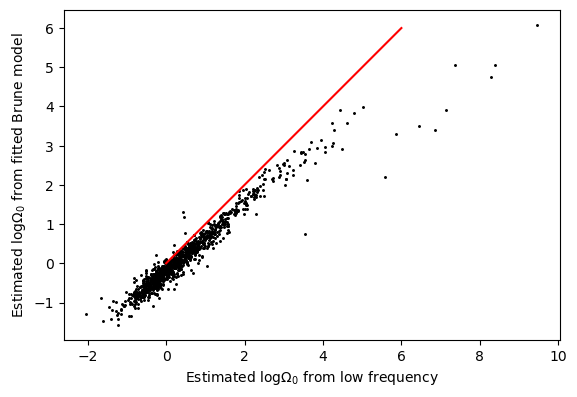

In [95]:

plt.figure()
plt.scatter(ev_target['logomega0'], ev_target['logomega0est'], c='k', s=5, marker='.')
plt.plot([0,6], [0,6], c='r')
plt.xlabel(r"Estimated log$\Omega_0$ from low frequency")
plt.ylabel(r"Estimated log$\Omega_0$ from fitted Brune model")
plt.gca().set_aspect('equal')
plt.show()


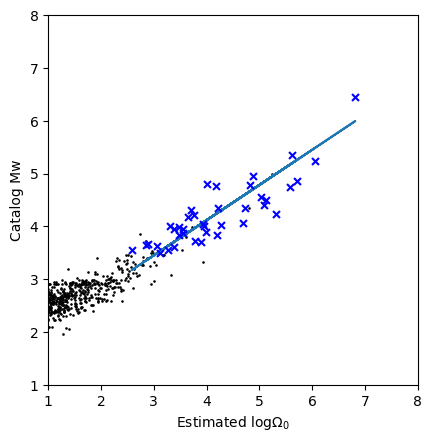

[-11.61134663   1.02066691]


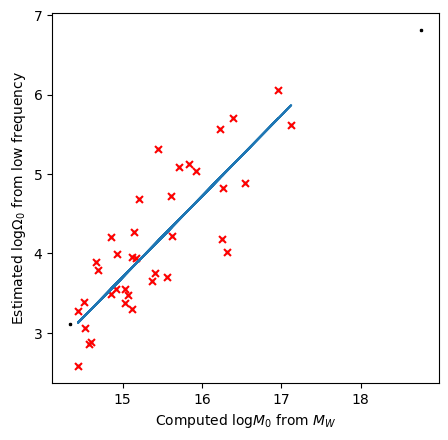

[-3.55896469  0.47764997]


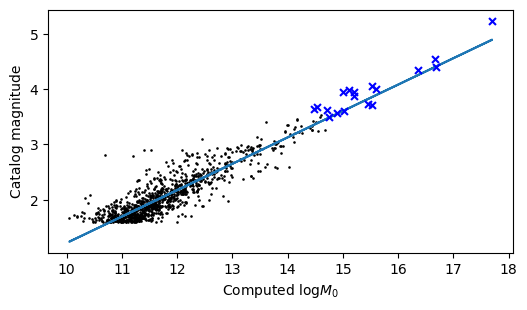

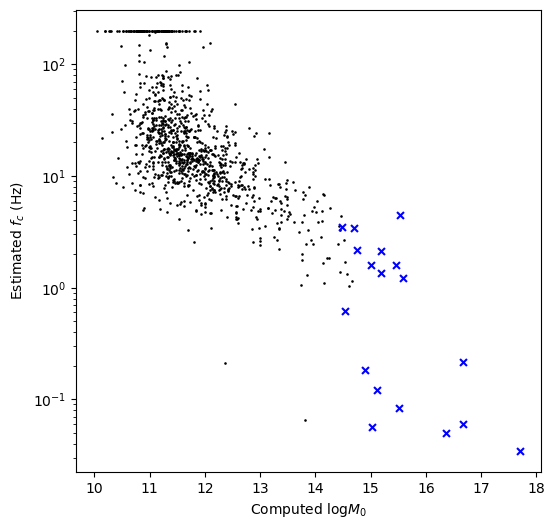

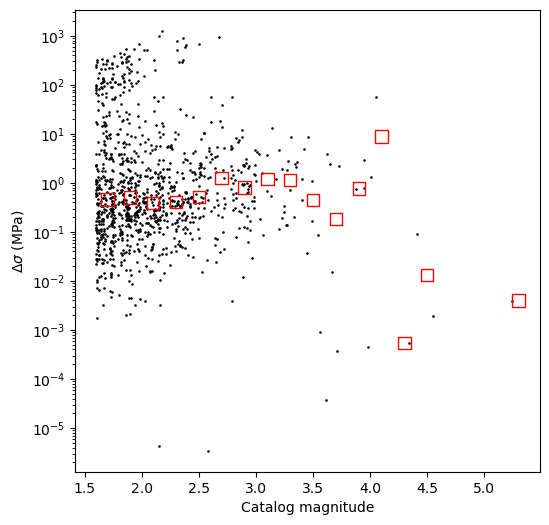

In [98]:
def slope_line(b, x):
    return 2/3 * x + b

def line(m, x):
    # m = [y-intercept, slope]
    return m[0] + m[1]*x


# Select only events with a moment magnitude
ev_Mw = ev[ev['qmag1type']=='Mw'].reset_index(drop=True)

# Compute log moments from moment magnitudes
# Kanamori 1977, Hanks and Kanamori 1979
ev_Mw['logm0'] = 1.5 * ev_Mw['qmag1'].values + 9.1

# filter for events in Mw_correction_range
ev_Mw_corr = ev_Mw[ev_Mw['qmag1']>=Mw_correction_range[0]]
ev_Mw_corr = ev_Mw_corr[ev_Mw_corr['qmag1']<=Mw_correction_range[1]]



x = ev_Mw['logomega0est'].values
y = ev_Mw['qmag1'].values

b_bf = fit_p_norm(x, y, slope_line, 1, 2)
y_bf = 2.0/3.0 * x + b_bf

plt.figure()
plt.scatter(ev_Mw['logomega0est'], ev_Mw['qmag1'], c='b', marker='x', s=25, zorder=10)
plt.scatter(ev['logomega0est'], ev['qmag1'], c='k', marker='.', s=3)
plt.plot(x, y_bf)
plt.xlabel(r"Estimated log$\Omega_0$")
plt.ylabel("Catalog Mw")
plt.xlim([1,8])
plt.ylim([1,8])
plt.gca().set_aspect('equal')
plt.show()


x = ev_Mw_corr['logm0'].values 
y = ev_Mw_corr['logomega0est'].values

m = fit_p_norm(x, y, line, [1,1], 1)
print(m)

moment_correction_factor = -1 * m[0]

plt.figure()
plt.scatter(ev_Mw['logm0'], ev_Mw['logomega0est'], c='k', marker='x', s=3)
plt.scatter(ev_Mw_corr['logm0'], ev_Mw_corr['logomega0est'], c='r', marker='x', 
    s=25, label=f'Events in range (Mw {Mw_correction_range[0]:.1f}-{Mw_correction_range[1]})')
plt.plot(x, m[0]+m[1]*x)
plt.xlabel(r"Computed log$M_0$ from $M_W$")
plt.ylabel(r"Estimated log$\Omega_0$ from low frequency")
plt.gca().set_aspect('equal')
plt.show()


####


# ev_target['logm0'] = ev_target['logomega0'] + moment_correction_factor
ev_target['logm0'] = ev_target['logomega0est'] + moment_correction_factor
# ev_target['logm0'] = (1/m[1]) * (ev_target['logomega0'] + moment_correction_factor)
ev_target['delsig'] = (7.0/16.0) * np.power(ev_target['fc'].values/(kP*beta), 3) * 10**ev_target['logm0'].values

x = ev_target['logm0'].values
y = ev_target['qmag1'].values

m = fit_p_norm(x, y, line, [-5,1], 1)

print(m)

plt.figure(figsize=(6,6))
plt.scatter(ev_target['logm0'][ev_target['qmag1type']=="Mw"], ev_target['qmag1'][ev_target['qmag1type']=="Mw"], c='b', marker='x', s=25, zorder=10)
plt.scatter(ev_target['logm0'], ev_target['qmag1'], c='k', marker='.', s=3)
plt.plot(x, m[0] + m[1]*x)
# plt.plot(x, -10 + x)
plt.xlabel(r"Computed log$M_0$")
plt.ylabel("Catalog magnitude")
# plt.xlim([9,17])
# plt.ylim([1,9])
plt.gca().set_aspect('equal')
plt.show()

# Log M0 vs fc
plt.figure(figsize=(6,6))
plt.scatter(ev_target['logm0'][ev_target['qmag1type']=="Mw"], ev_target['fc'][ev_target['qmag1type']=="Mw"], c='b', marker='x', s=25, zorder=10)
plt.scatter(ev_target['logm0'], ev_target['fc'], c='k', marker='.', s=3)
# plt.plot(x, -10 + x)
plt.xlabel(r"Computed log$M_0$")
plt.ylabel(r"Estimated $f_c$ (Hz)")
plt.yscale('log')
# plt.xlim([9,17])
# plt.ylim([1,9])
# plt.gca().set_aspect('equal')
plt.show()



mag_bin_edges = np.arange(1, 6.1, 0.2)
mag_bins = (mag_bin_edges[1:] + mag_bin_edges[:-1]) / 2
median_logdelsig, _, _ = scipy.stats.binned_statistic(
    ev_target['qmag1'].values, 
    np.log10(ev_target['delsig'].values), 
    bins=mag_bin_edges,
    statistic='median'
)
median_delsig = 10**median_logdelsig

plt.figure(figsize=(6,6))
plt.scatter(ev_target['qmag1'], ev_target['delsig']*1E-6, c='k', marker='.', s=3)
plt.scatter(mag_bins, median_delsig*1E-6, edgecolors='r', marker='s', s=80, facecolors='none')
plt.xlabel("Catalog magnitude")
plt.ylabel(r"$\Delta \sigma$ (MPa)")
plt.yscale('log')
# plt.xlim([9,17])
# plt.ylim([1,9])
# plt.gca().set_aspect('equal')
plt.show()


(array([  2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   2.,   0.,   1.,   1.,   3.,   6.,   6.,   5.,  12.,  13.,
         25.,  32.,  37.,  48.,  57.,  85.,  96., 100.,  70.,  65.,  65.,
         47.,  47.,  35.,  28.,  26.,  15.,  16.,   7.,   9.,  15.,  24.,
         14.,  14.,  21.,   9.,   5.,   4.]),
 array([-5.46218291, -5.29088056, -5.1195782 , -4.94827585, -4.77697349,
        -4.60567113, -4.43436878, -4.26306642, -4.09176407, -3.92046171,
        -3.74915936, -3.577857  , -3.40655465, -3.23525229, -3.06394994,
        -2.89264758, -2.72134523, -2.55004287, -2.37874052, -2.20743816,
        -2.03613581, -1.86483345, -1.6935311 , -1.52222874, -1.35092639,
        -1.17962403, -1.00832168, -0.83701932, -0.66571697, -0.49441461,
        -0.32311226, -0.1518099 ,  0.01949245,  0.19079481,  0.36209716,
         0.53339952,  0.70470187,  0.87600423,  1.04730658,  1.21860894,
         1.38991129,  1.56121365,  1.732516  ,  1.90381836,  2.07512071,
 

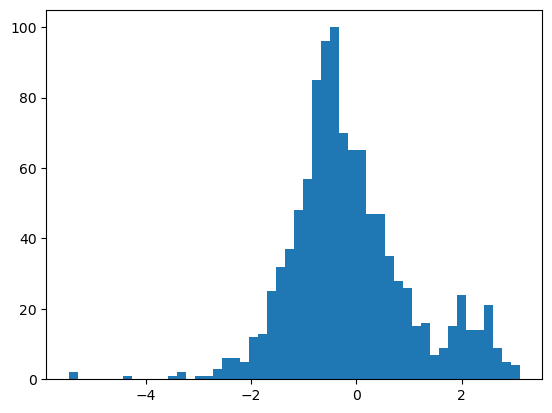

In [109]:
plt.hist(np.log10(ev_target['delsig']/1E6), 50)

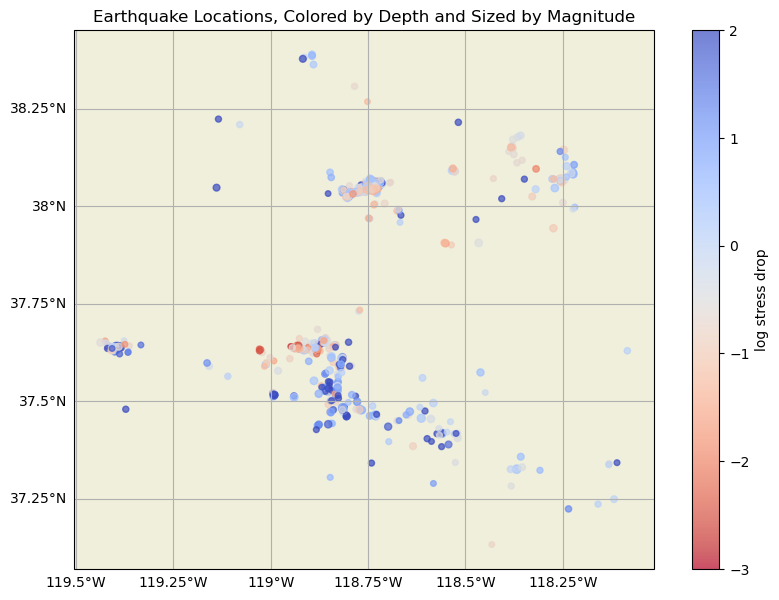

In [110]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# Plotting the earthquakes on a map
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adding features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Scatter plot, colored by depth and sized by magnitude
sc = ax.scatter(ev_target['qlon'], ev_target['qlat'], c=np.log10(ev_target['delsig']/1E6), 
    s=ev_target['qmag1']*10, cmap='coolwarm_r', transform=ccrs.PlateCarree(), alpha=0.7,
    vmin=-3, vmax=2)

# ax.scatter(inv['slon'], inv['slat'], c='orange', s=40, marker='v', edgecolors='k', transform=ccrs.PlateCarree())


# ax.scatter(np.mean(event_lon_range), np.mean(event_lat_range), c='k', s=50, marker='x', transform=ccrs.PlateCarree())

# plot_circle(np.mean(event_lon_range), np.mean(event_lat_range), station_maxradius, ax, transform=ccrs.PlateCarree())

# Adding a color bar
cb = plt.colorbar(sc, ax=ax, orientation='vertical', label='Depth (km)')
cb.set_label('log stress drop')

# Setting the title
plt.title('Earthquake Locations, Colored by Depth and Sized by Magnitude')

# Adding gridlines and labels for lat/lon tick marks
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Display the plot
plt.show()